In [1]:
import os
import re
import nibabel as nib
from nibabel.affines import apply_affine
import numpy.linalg as npl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [2]:
def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")
        
# slice_0 = t2s_img_data[int(t2s_img_data.shape[0]/2), :, :]
# slice_1 = t2s_img_data[:, int(t2s_img_data.shape[1]/2), :]
# slice_2 = t2s_img_data[:, :, int(t2s_img_data.shape[2]/2)]
# show_slices([slice_0, slice_1, slice_2])

In [3]:
centres_df = pd.read_csv('subject-centres.csv', dtype={'patientId': str, 'centerId': str, 'include': np.int8})
centres_df = centres_df[centres_df['include'] == 1] # Remove subjects with data issues.
centre8_subjects = centres_df[centres_df['centerId']=='8']['patientId'].tolist()

### Reading in Patch Data

In [4]:
root_dir = os.path.join('Data', 'SCSeg')
subjects = os.listdir(root_dir)
n_lesions={}; lesion_data={}; t2_data={}; t2s_data={}; t2_SC_data={}; t2s_SC_data={};

for subj in subjects:
    lesion_img = nib.load(os.path.join(root_dir, subj, 'SC', 'labelLesion.nii.gz'))
    lesion_img_data = lesion_img.get_fdata()
    n_lesions[subj] = max(np.unique(lesion_img_data.ravel()))

    res_dir = os.path.join(root_dir, subj, 'SC', 'res')
    lesion_data[subj] = np.load(os.path.join(res_dir, 'patches_lesion.npy'))
    t2_data[subj]     = np.load(os.path.join(res_dir, 'patches_t2.npy'))
    t2s_data[subj]    = np.load(os.path.join(res_dir, 'patches_t2s.npy'))
    t2_SC_data[subj]  = np.load(os.path.join(res_dir, 'patches_t2_SC.npy'))
    t2s_SC_data[subj] = np.load(os.path.join(res_dir, 'patches_t2s_SC.npy'))
        
    if not (lesion_data[subj].shape == t2_data[subj].shape) & (lesion_data[subj].shape == t2s_data[subj].shape):
        print('Different shapes for subj {}:\n\tLesion: {}, T2: {}, T2*: {}'.format(subj, lesion.shape, t2.shape, t2s.shape))

Combine all data, but take only subjects from centre 8.

In [7]:
# Collapse all patches into one Numpy array.
patches_lesion = np.concatenate([lesion_data[subj] for subj in centre8_subjects])
patches_t2 = np.concatenate([t2_data[subj] for subj in centre8_subjects])
patches_t2s = np.concatenate([t2s_data[subj] for subj in centre8_subjects])
patches_t2_SC = np.concatenate([t2_SC_data[subj] for subj in centre8_subjects])
patches_t2s_SC = np.concatenate([t2s_SC_data[subj] for subj in centre8_subjects])
# Record which subject corresponds to which patch
patches_subjects = [subj for subj in centre8_subjects for i in range(0,lesion_data[subj].shape[0])]

print("Total Patches: {}\n Lesion Patches:\t{}\n T2 Patches:\t\t{}\n T2* Patches:\t\t{}\n T2 SC Patches:\t\t{}\n T2* SC Patches:\t{}"
      .format(len(patches_subjects), patches_lesion.shape, patches_t2.shape, patches_t2s.shape, patches_t2_SC.shape, patches_t2s_SC.shape))

Total Patches: 269
 Lesion Patches:	(269, 48, 48, 48)
 T2 Patches:		(269, 48, 48, 48)
 T2* Patches:		(269, 48, 48, 48)
 T2 SC Patches:		(269, 48, 48, 48)
 T2* SC Patches:	(269, 48, 48, 48)


In [16]:
def get_bins(data, bin_width, xmin=None, xmax=None):
    xmin = np.min(data) if xmin is None else xmin
    if xmax is None:
        xmax = bin_width*np.ceil(np.max(data)/bin_width)
    return np.linspace(xmin, xmax, 1+int((xmax-xmin)/bin_width))

def plot_hist(data, bin_width, xmin=None, xmax=None, prop=False, xlab='', ylab='', title='', subtitle=''):
    weights = np.ones(len(data))/len(data) if prop==True else None
    plt.hist(data, bins=get_bins(data, bin_width, xmin, xmax), edgecolor='lightgray', weights=weights)
    plt.axvline(np.mean(data), color='tab:orange', linestyle='dashed', label='mean')
    plt.xlabel(xlab, fontsize=16)
    plt.ylabel(ylab, fontsize=16)
    plt.suptitle(title, fontsize=18)
    plt.title(subtitle, fontsize=14)
    plt.legend()
    plt.show()

### Summarising Intensities

#### Intensity Distributions Across Centres

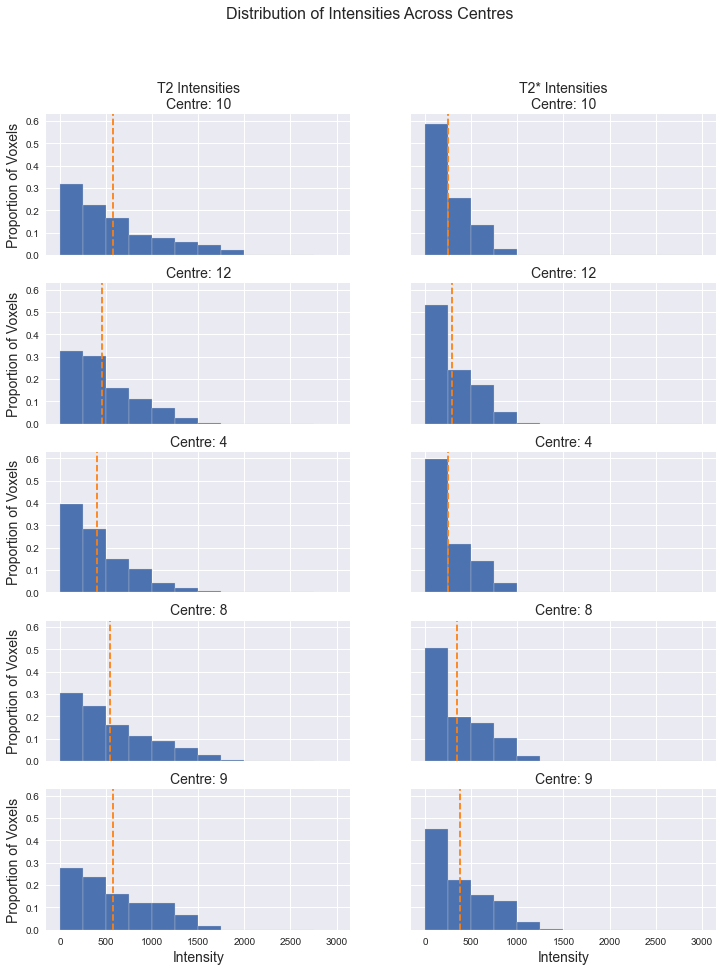

In [7]:
fig, ax = plt.subplots(5, 2, figsize= (12, 15), sharex=True, sharey=True)

t2_bins = get_bins(np.concatenate(list(t2_data.values())), bin_width=250)
t2s_bins = get_bins(np.concatenate(list(t2s_data.values())), bin_width=250)

for i,c in enumerate(np.unique(centres_df['centerId'])):
    c_subj = centres_df[centres_df['centerId']==c]['patientId']
    
    centre_t2_values = np.concatenate([t2_data[str(s)].ravel() for s in c_subj])
    ax[i, 0].hist(centre_t2_values, weights=np.ones(len(centre_t2_values)) / len(centre_t2_values),
              edgecolor='lightgray', bins=t2_bins)
    ax[i, 0].axvline(centre_t2_values.mean(), color='tab:orange', linestyle='dashed')
    ax[i, 0].set_ylabel('Proportion of Voxels', fontsize=14)
    title = 'T2 Intensities\nCentre: {}' if i==0 else 'Centre: {}'
    ax[i, 0].set_title(title.format(c), fontsize=14)
    
    centre_t2s_values = np.concatenate([t2s_data[str(s)].ravel() for s in c_subj])
    ax[i, 1].hist(centre_t2s_values, weights=np.ones(len(centre_t2s_values)) / len(centre_t2s_values),
              edgecolor='lightgray', bins=t2s_bins)        
    ax[i, 1].axvline(centre_t2s_values.mean(), color='tab:orange', linestyle='dashed')
    title = 'T2* Intensities\nCentre: {}' if i==0 else 'Centre: {}'
    ax[i, 1].set_title(title.format(c), fontsize=14)

ax[4,0].set_xlabel('Intensity', fontsize=14)
ax[4,1].set_xlabel('Intensity', fontsize=14)
plt.suptitle('Distribution of Intensities Across Centres', fontsize=16)
plt.show()

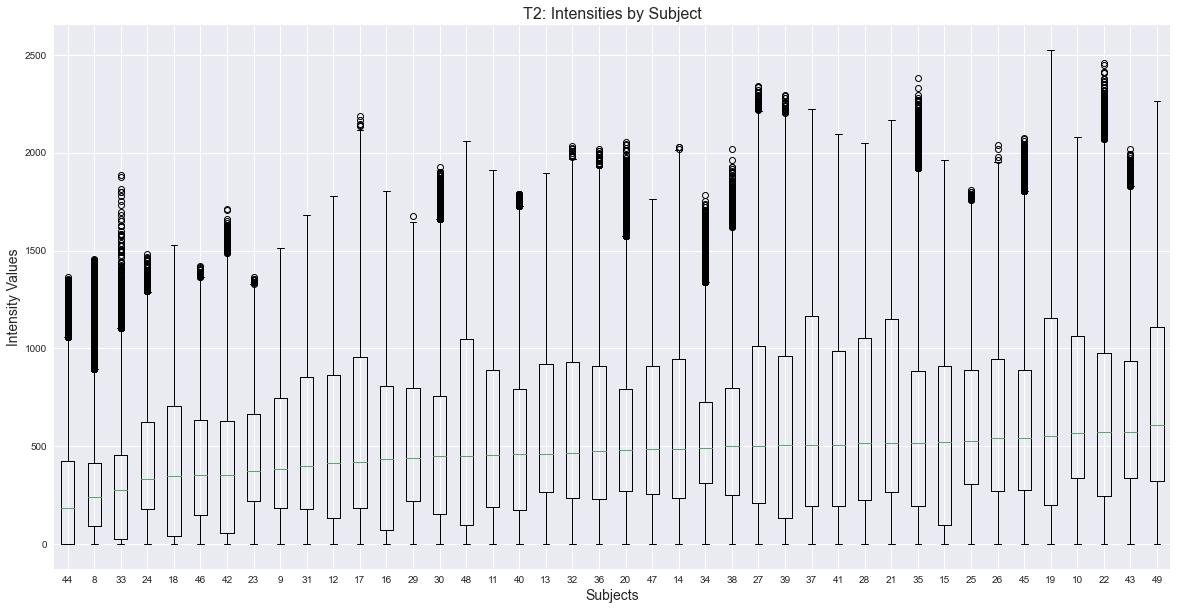

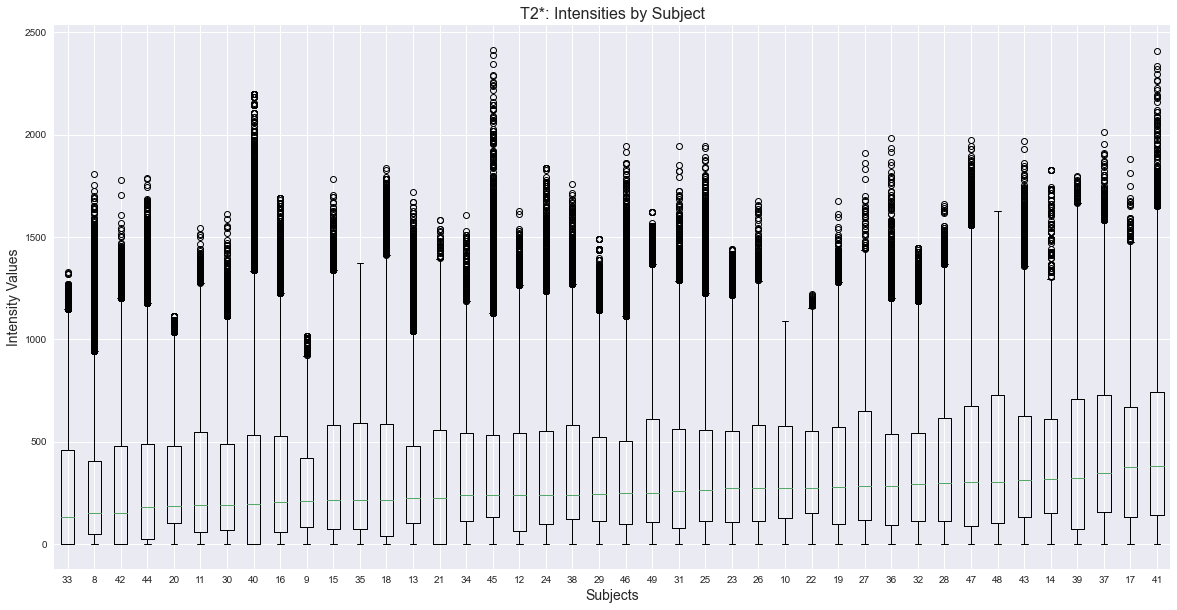

In [8]:
data_flattened = [t2_data[subj].ravel() for subj in centre8_subjects]
data_sorted, subj_sorted = zip(*sorted(zip(data_flattened, centre8_subjects), key=lambda x: np.median(x[0])))

plt.figure(figsize=(20,10))
_ = plt.boxplot(data_sorted)
_ = plt.xticks(range(1,43), labels=subj_sorted)
plt.xlabel('Subjects', fontsize=14)
plt.ylabel('Intensity Values', fontsize=14)
plt.title('T2: Intensities by Subject',fontsize=16)
plt.show()

data_flattened = [t2s_data[subj].ravel() for subj in centre8_subjects]
data_sorted, subj_sorted = zip(*sorted(zip(data_flattened, centre8_subjects), key=lambda x: np.median(x[0])))

plt.figure(figsize=(20,10))
_ = plt.boxplot(data_sorted)
_ = plt.xticks(range(1,43), labels=subj_sorted)
plt.xlabel('Subjects', fontsize=14)
plt.ylabel('Intensity Values', fontsize=14)
plt.title('T2*: Intensities by Subject',fontsize=16)
plt.show()

##### Show the top patch and bottom patch separately for each subject to assess intra-patient and inter-patient variability.
** Note: the first patch in the data is from the bottom of the image, and the last patch is from the top of the image. This results from the order in SCT processing, 0 in the z-axis corresponds to the bottom of the image.

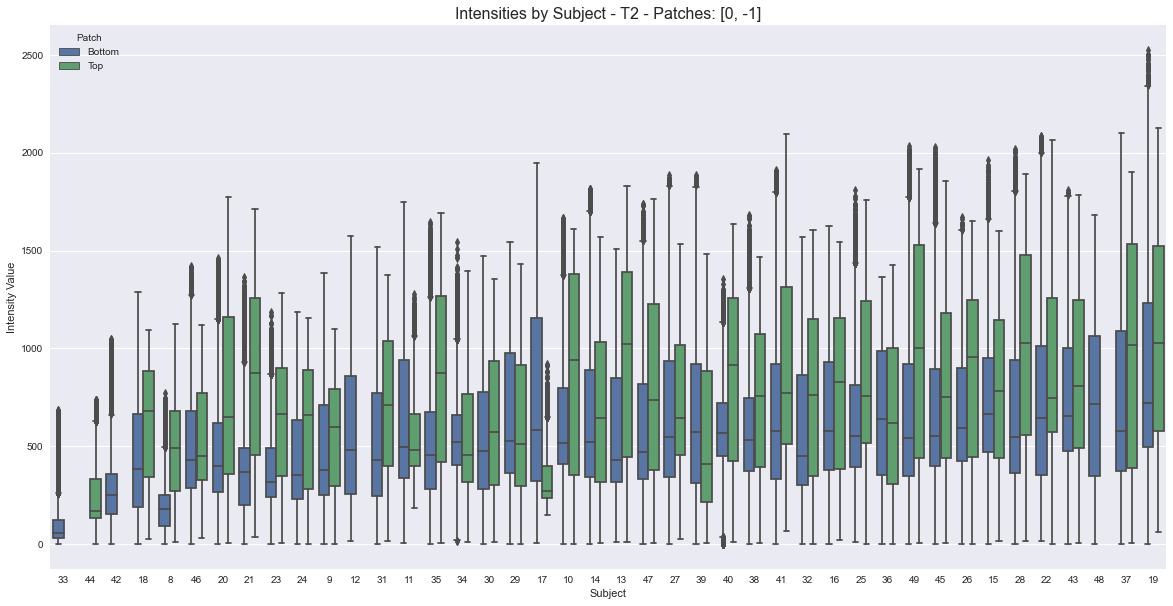

In [8]:
def boxplot_subj_patch_split(data, patch_ind=[0,-1], title=''):
    data_flattened = [data[subj][i].ravel() for subj in centre8_subjects for i in patch_ind]

    bt_patches_wide_df = pd.DataFrame(np.array(data_flattened).transpose(), 
                                      columns=[subj + '_' + patch for subj in centre8_subjects for patch in ['Bottom', 'Top']])
    bt_patches_long_df = bt_patches_wide_df.melt(var_name='Subject_Patch', value_name='Intensity Value')
    bt_patches_long_df[['Subject','Patch']] = bt_patches_long_df.Subject_Patch.str.split('_', expand=True)

    plt.figure(figsize=(20,10))
    sns.boxplot(x='Subject', y='Intensity Value', hue='Patch', 
                data=bt_patches_long_df[bt_patches_long_df['Intensity Value']>0], 
               order=bt_patches_long_df[bt_patches_long_df['Intensity Value']>0].groupby('Subject').median().sort_values('Intensity Value').index
               )
    plt.title('Intensities by Subject - {} - Patches: {}'.format(title, str(patch_ind)),fontsize=16)

boxplot_subj_patch_split(t2_data, patch_ind=[0,-1], title='T2')

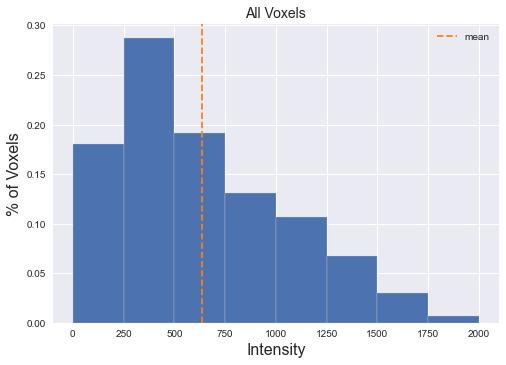

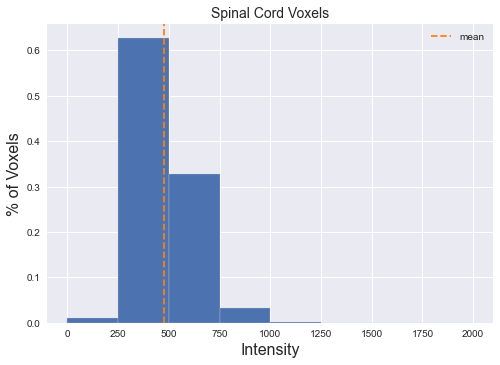

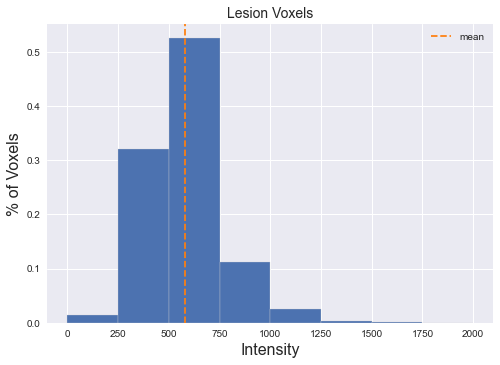

In [22]:
# (data, bin_width, xlab='', ylab='', title='', subtitle='')
plot_hist(patches_t2[patches_t2>0].ravel(), prop=True, bin_width=250, xmin=0, xmax=2000, xlab='Intensity', ylab='% of Voxels', subtitle='All Voxels')
plot_hist(patches_t2_SC[patches_t2_SC>0].ravel(), prop=True, bin_width=250, xmin=0, xmax=2000, xlab='Intensity', ylab='% of Voxels', subtitle='Spinal Cord Voxels')
plot_hist(patches_t2[patches_lesion==1].ravel(), prop=True, bin_width=250, xmin=0, xmax=2000, xlab='Intensity', ylab='% of Voxels', subtitle='Lesion Voxels')

In [7]:
# Function to collapse the data arrays and concatenate all subject data.
collapse = lambda data: np.concatenate([data[subj].ravel() for subj in centre8_subjects])

all_data_df = pd.DataFrame(
    np.concatenate((
        np.array([subj for subj in centre8_subjects for i in range(t2_data[subj].size)]).reshape(1,-1),
        np.array([collapse(data) for data in [t2_data, t2s_data, t2_SC_data, t2s_SC_data, lesion_data]])
        )
    ).transpose(),
    columns=['Subject', 'T2', 'T2s', 'T2_SC', 'T2s_SC', 'Lesion']
)

all_data_df[['T2', 'T2s', 'T2_SC', 'T2s_SC', 'Lesion']] = all_data_df[['T2', 'T2s', 'T2_SC', 'T2s_SC', 'Lesion']].apply(pd.to_numeric)

all_data_df['category'] = np.where(all_data_df['Lesion']==1, 1, np.where(all_data_df['T2_SC']!=-1, 2, 3))

In [10]:
all_data_df.dtypes

Subject    object
T2         object
T2s        object
T2_SC      object
T2s_SC     object
Lesion     object
dtype: object

Text(0.5, 1.0, 'T2 Intensities (1=Lesion, 2=Spinal Cord (Non-Lesion), 3=Non-Spinal Cord)')

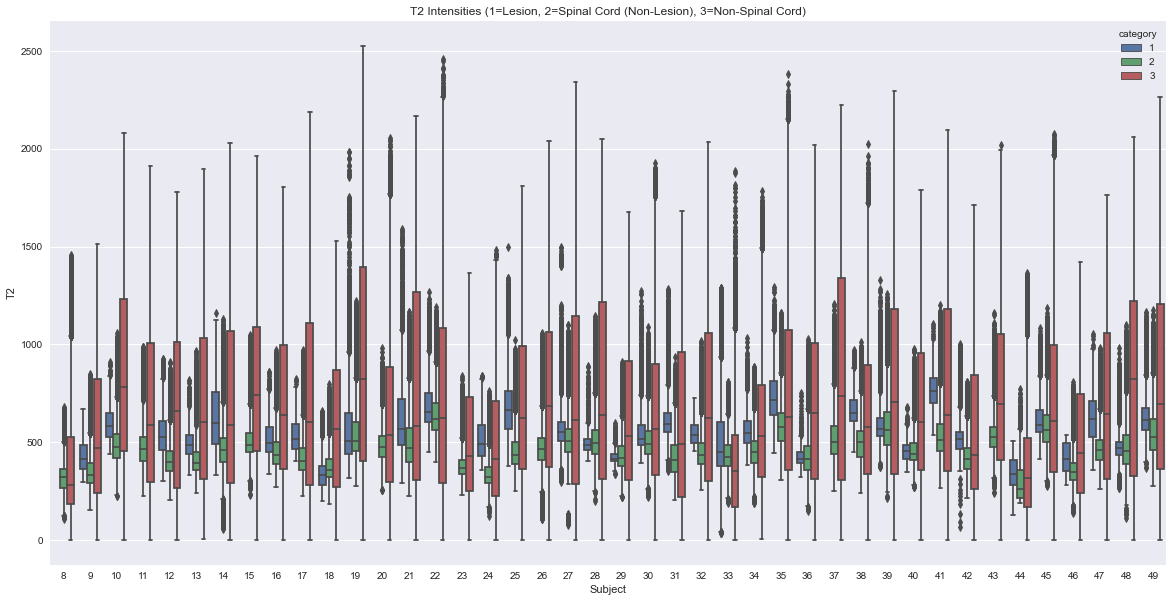

In [19]:
plt.figure(figsize=(20,10))
sns.boxplot(x='Subject', y='T2', hue='category', 
                data=all_data_df[all_data_df['T2']>0]
#             labels=['Lesion', 'Spinal Cord (Non-lesion)', 'Non-Spinal Cord']
#                order=
               )
plt.title('T2 Intensities (1=Lesion, 2=Spinal Cord (Non-Lesion), 3=Non-Spinal Cord)')

#### TODO: Intensity Distribution Across Patches
- Could have a histogram of the mean (or std. dev.) intensity per patch.
- Maybe boxplots of intensity, with columns split by patch and rows split by subject.
- Boxplot of mean patch intensity, columns split by subject. 
- Histogram per subject, coloured by patch number.
- Analyse global differences across centres.

- Split subject into two patches (top/bottom)
- Look at patches containing lesions only.
- Could split - lesion, non-lesion spinal cord, and non-spinal cord intensities.

### Summarising Lesion & Patch Data

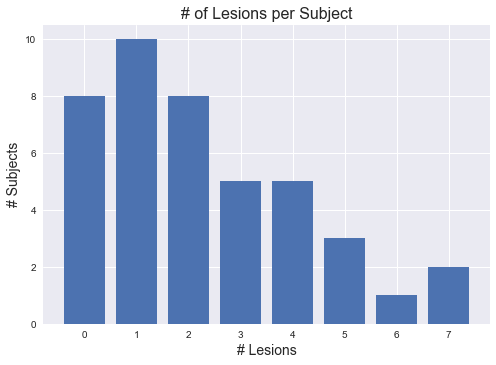

In [9]:
lesion_count = np.unique([n_lesions[subj] for subj in centre8_subjects], return_counts=True)
plt.bar(lesion_count[0], lesion_count[1])
plt.xlabel('# Lesions', fontsize=14)
plt.ylabel('# Subjects', fontsize=14)
plt.title('# of Lesions per Subject', fontsize=16)
plt.show()

In [11]:
lesion_voxel_count = np.unique(patches_lesion, return_counts=True)[1]
lesion_voxel_prop = lesion_voxel_count[1]/sum(lesion_voxel_count)
print('Overall in the dataset, {}% of voxels contain a lesion.\n\t({} voxels out of a total {})'.format(
    round(lesion_voxel_prop*100, 3), lesion_voxel_count[1], sum(lesion_voxel_count)))

lesion_voxel_raw_count_patches = [np.unique(patch, return_counts=True)[1] for patch in patches_lesion]
lesion_voxel_count_patches = [0 if len(x)==1 else x[1] for x in lesion_voxel_raw_count_patches]
lesion_voxel_prop_patches = [0 if len(x)==1 else x[1]/sum(x) for x in lesion_voxel_raw_count_patches]
total_voxel_count_patches = [sum(x) for x in lesion_voxel_raw_count_patches]

df_patch_count = pd.DataFrame(zip(patches_subjects, lesion_voxel_prop_patches, lesion_voxel_count_patches, total_voxel_count_patches), 
                              columns=['subject', 'prop_lesion', 'voxels_lesion', 'total_voxels'])

Overall in the dataset, 0.467% of voxels contain a lesion.
	(138945 voxels out of a total 29749248)


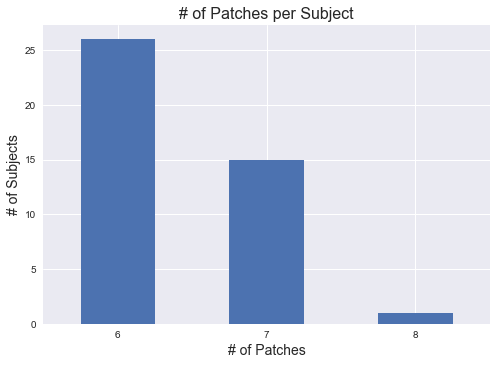

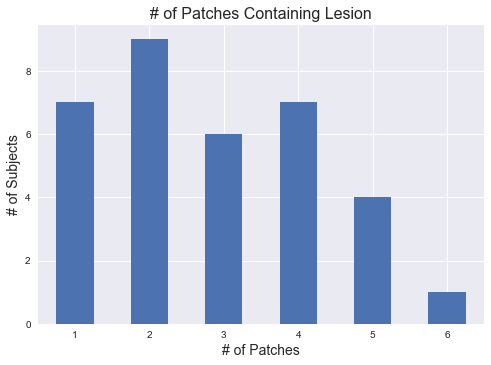

In [12]:
df_patch_count['subject']  \
    .value_counts().value_counts().sort_index()  \
    .plot(kind='bar')

plt.title('# of Patches per Subject', fontsize=16)
plt.ylabel('# of Subjects', fontsize=14)
plt.xlabel('# of Patches', fontsize=14)
plt.xticks(rotation='horizontal')
plt.show()

df_patch_count[df_patch_count['voxels_lesion'] > 0]['subject']  \
    .value_counts().value_counts().sort_index()  \
    .plot(kind='bar')

plt.title('# of Patches Containing Lesion', fontsize=16)
plt.ylabel('# of Subjects', fontsize=14)
plt.xlabel('# of Patches', fontsize=14)
plt.xticks(rotation='horizontal')
plt.show()

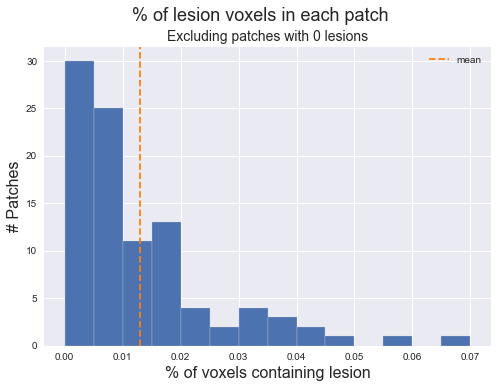

In [29]:
plot_hist([p for p in lesion_voxel_prop_patches if p>0], 0.005, xlab='% of voxels containing lesion', ylab='# Patches', 
          title='% of lesion voxels in each patch', subtitle = 'Excluding patches with 0 lesions')

# plot_hist(lesion_voxel_count_patches, 500, xlab='# of voxels containing lesion', ylab='# Patches', title='Number of lesion voxels in each patch')

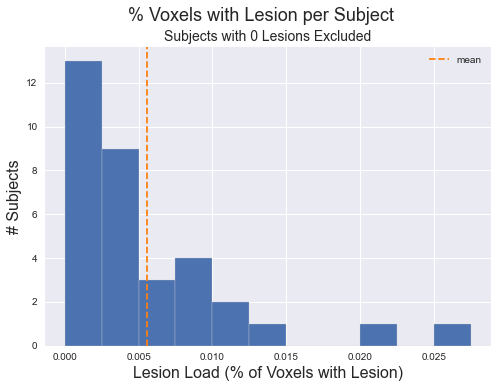

In [32]:
totals_by_subj = df_patch_count.groupby('subject')[['voxels_lesion', 'total_voxels']].sum()

totals_by_subj['prop_lesion'] = totals_by_subj['voxels_lesion']/totals_by_subj['total_voxels']

# plot_hist(totals_by_subj['voxels_lesion'], bin_width=2500, 
#           xlab='# of Lesion Voxels', ylab='# Subjects', title='Total Lesion Voxels per Subject')
# plot_hist(totals_by_subj[totals_by_subj['voxels_lesion']>0]['voxels_lesion'], bin_width=2500,
#         xlab='# of Lesion Voxels', ylab='# Subjects', title='Total Lesion Voxels per Subject',
#          subtitle='Subjects with 0 Lesions Excluded')

# # Plot Distrbution of % Lesion Voxels rather than Absolute Number of Voxels.
# plot_hist(totals_by_subj['prop_lesion'], bin_width=0.002,
#         xlab='% of Voxels with Lesion', ylab='# Subjects', title='% Voxels with Lesion per Subject')
plot_hist(totals_by_subj[totals_by_subj['prop_lesion']>0]['prop_lesion'], bin_width=0.0025,
        xlab='Lesion Load (% of Voxels with Lesion)', ylab='# Subjects', title='% Voxels with Lesion per Subject',
         subtitle='Subjects with 0 Lesions Excluded')

Text(0.5, 0, 'Subject')

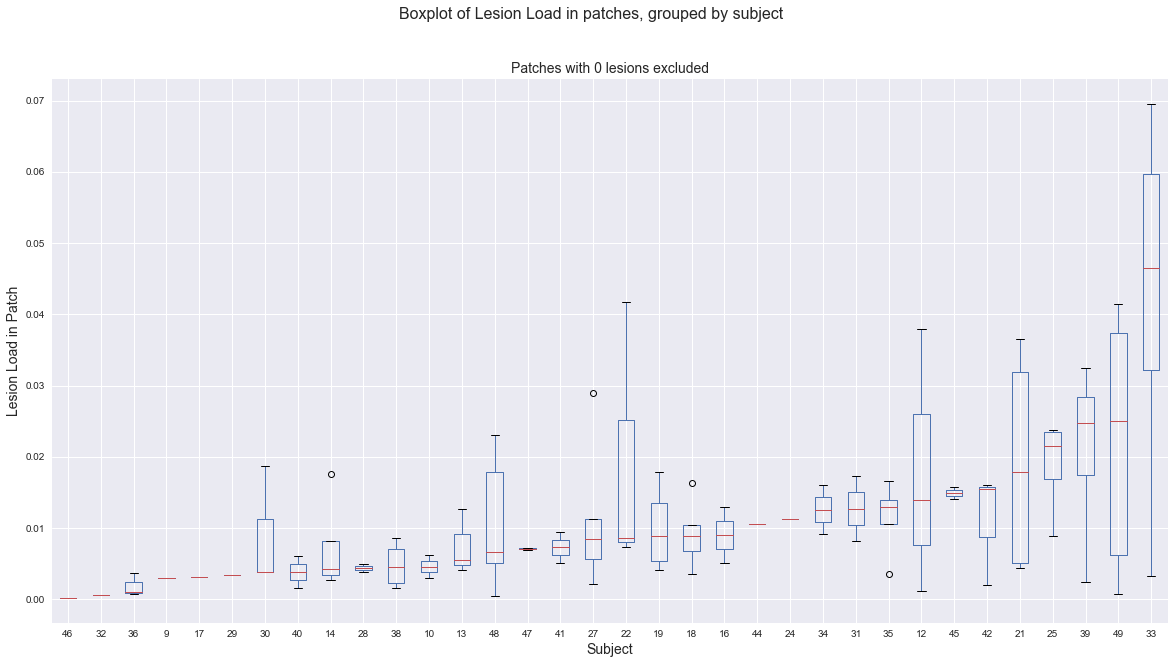

In [54]:
# df_patch_count.boxplot(column='prop_lesion', by='subject', figsize=(20,10))
# plt.suptitle('Boxplot of Lesion load in patches, grouped by subject.\n', fontsize=16)
# plt.ylabel('% lesion voxels in patch', fontsize=14)
# plt.xlabel('Subject', fontsize=14)

# grouped = df_patch_count.groupby('subject')
# df_sort =  pd.DataFrame({col:vals['prop_lesion'] for col,vals in grouped})
# df_sort = df_sort[df_sort.median().sort_values().index]
# df_sort.boxplot(figsize=(20,10))

grouped = df_patch_count[df_patch_count['prop_lesion'] > 0].groupby('subject')
df_sort =  pd.DataFrame({col:vals['prop_lesion'] for col,vals in grouped})
df_sort = df_sort[df_sort.median().sort_values().index]
df_sort.boxplot(figsize=(20,10))
plt.suptitle('Boxplot of Lesion Load in patches, grouped by subject', fontsize=16)
plt.title('Patches with 0 lesions excluded', fontsize=14)
plt.ylabel('Lesion Load in Patch', fontsize=14)
plt.xlabel('Subject', fontsize=14)